In [44]:
# !pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate gradio torch

In [45]:
import gradio as gr
from base64 import b64encode
import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import torchvision.transforms as T

In [46]:
torch.manual_seed(1)
logging.set_verbosity_error()
torch_device = "cuda"

In [47]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [48]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

In [49]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [50]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [51]:
def generate_with_embs(text_embeddings, seed, max_length):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 10            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    # max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]


In [52]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

In [53]:
def embed_style(prompt, style_embed, style_seed):
    # Tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)

    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)

    replacement_token_embedding = style_embed.to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    max_length = text_input.input_ids.shape[-1]
    return generate_with_embs(modified_output_embeddings, style_seed, max_length)

In [54]:
def loss_style(prompt, style_embed, style_seed):
    # Tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)

    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)

    # The new embedding - our special birb word
    replacement_token_embedding = style_embed.to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    max_length = text_input.input_ids.shape[-1]
    return generate_loss_based_image(modified_output_embeddings, style_seed,max_length)

In [55]:
def sepia_loss(images):
    sepia_tone = 0.393 * images[:,0] + 0.769 * images[:,1] + 0.189 * images[:,2]
    error = torch.abs(sepia_tone - 0.5).mean()
    return error

In [56]:
def generate_loss_based_image(text_embeddings, seed, max_length):

    height = 64
    width = 64
    num_inference_steps = 10
    guidance_scale = 8
    generator = torch.manual_seed(64)
    batch_size = 1
    loss_scale = 200

    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps+1)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    sched_out = None

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        ### ADDITIONAL GUIDANCE ###
        if i%5 == 0 and i>0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            scheduler._step_index -= 1
            latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)


            # Calculate loss
            loss = sepia_loss(denoised_images) * loss_scale

            # Occasionally print it out
            # if i%10==0:
            print(i, 'loss:', loss)

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2
            # To PIL Images
            im_t0 = latents_to_pil(latents_x0)[0]
            im_next = latents_to_pil(latents)[0]

        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]


<ipython-input-51-a473defcf007>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-56-6cfa601fc02a>:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/11 [00:00<?, ?it/s]

5 loss: tensor(95.8419, device='cuda:0', grad_fn=<MulBackward0>)
10 loss: tensor(74.9286, device='cuda:0', grad_fn=<MulBackward0>)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

5 loss: tensor(83.9427, device='cuda:0', grad_fn=<MulBackward0>)
10 loss: tensor(60.9814, device='cuda:0', grad_fn=<MulBackward0>)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

5 loss: tensor(87.1757, device='cuda:0', grad_fn=<MulBackward0>)
10 loss: tensor(58.7387, device='cuda:0', grad_fn=<MulBackward0>)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

5 loss: tensor(104.2495, device='cuda:0', grad_fn=<MulBackward0>)
10 loss: tensor(58.9597, device='cuda:0', grad_fn=<MulBackward0>)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

5 loss: tensor(89.9151, device='cuda:0', grad_fn=<MulBackward0>)
10 loss: tensor(75.6533, device='cuda:0', grad_fn=<MulBackward0>)


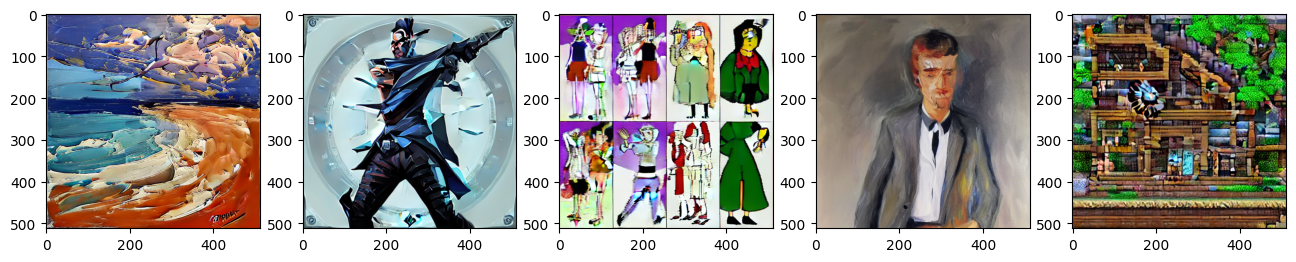

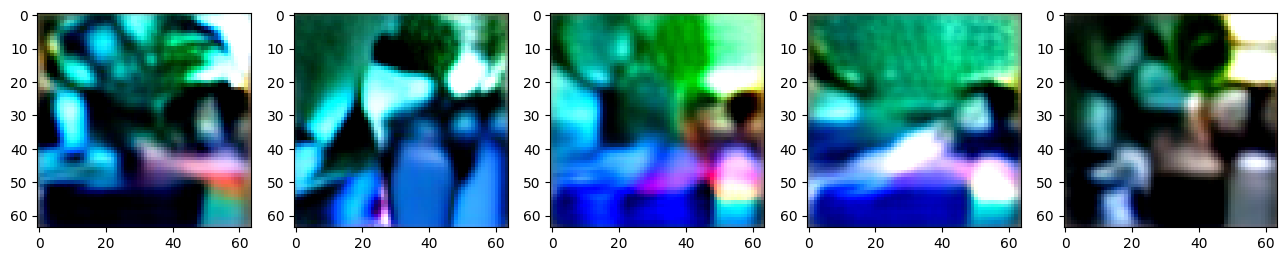

In [65]:
import matplotlib.pyplot as plt

STYLE_LIST = ['oil_style.bin', 'valorant_style.bin', 'cartoon_syle.bin', 'space_style.bin', 'terraria_syle.bin']
STYLE_SEEDS = [32, 64, 128, 16, 8]

# prompt = 'a cat in style of puppy'
prompt = 'man in style of puppy'

generated_image = []
loss_generated_img = []
style_name = []

for idx, style_file in enumerate(STYLE_LIST):
    style_seed = STYLE_SEEDS[idx]
    style_dict = torch.load(style_file)
    style_embed = [v for v in style_dict.values()]
    # print(style_embed[0])

    generated_image.append(embed_style(prompt, style_embed[0], style_seed))
    loss_generated_img.append(loss_style(prompt, style_embed[0], style_seed))
    style_name.append(style_file)


fig, axs = plt.subplots(1, len(generated_image), figsize=(16, 4))
for c in range(len(generated_image)):
    axs[c].imshow(generated_image[c])
plt.show()

fig, axs = plt.subplots(1, len(loss_generated_img), figsize=(16, 4))
for c in range(len(loss_generated_img)):
    axs[c].imshow(loss_generated_img[c])
plt.show()

